![alt text](STAR_MELT_logo.png "STAR_MELT")

# STAR-MELT Notebook for viewing spectra and Gaussian fitting of lines

Welcome to this example notebook for STAR-MELT.\
This notebook will use the example FITS files to show you how to use STAR-MELT on your own data.\
Additional functions at the end of the notebook can be copied to where needed.

### Notebook tips:
* ***Shift + Enter on a code cell/block to run it and advance to the next cell.***
* Can re-run blocks out of order as long as the variables are already there

In [ ]:
#if running on google colab, run this cell!
from google.colab import output
output.enable_custom_widget_manager()
!git clone https://github.com/justyncw/STAR_MELT
os.chdir('STAR_MELT/')

In [ ]:
#Packages required by STAR-MELT, some are not used directly in this notebook, but called by the modules, check that they are all installed here
import time
from matplotlib import *
from matplotlib.pyplot import *
import numpy as np
import pandas as pd
import astropy
from astropy.time import Time
import astropy.units as u
from astropy.coordinates import SkyCoord, EarthLocation
from astropy.stats import sigma_clip
from astroquery.simbad import Simbad
from astropy.timeseries import LombScargle
import numpy.ma as ma
import os
from PyAstronomy import pyasl
from lmfit.models import GaussianModel, LinearModel
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy.signal import find_peaks_cwt
from scipy.signal import argrelextrema
from ESO_fits_get_spectra import *
from ESP_fits_get_spectra import *
from utils_data import *
from utils_spec import *
from utils_physics import *
import utils_shared_variables as USH
from utils_saha_av import *
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widget
from IPython.display import display,clear_output,Image
import qgridnext as gqrid
#import imageio as io


#### If you change which %matplotlib magic command here you must restart the notebook

In [2]:
#for notebook/slides
#%matplotlib notebook 
#for lab
%matplotlib widget
#for new window plots
#%matplotlib qt
%reload_ext autoreload
%autoreload 2

In [3]:
rcParams.update({'figure.max_open_warning': 50})
rcParams['figure.dpi'] = 100
matplotlib.rc('font', family='serif',size=14)
USH.fig_size_s=(8,6)
USH.fig_size_l=(9,5)
USH.fig_size_n=(9,3)

In [4]:
# The line table used in the emission line matching will be automatically selected 
# depending on which instrument is selected. This block is just to view the line list.
line_table=USH.line_table
line_table=USH.line_table_prev_obs

#uncomment below if you want to see the line table in qgrid
#qgrid_widget1 = qgrid.show_grid(line_table, show_toolbar=False,grid_options={'forceFitColumns': False, 'defaultColumnWidth': 75})
#display(qgrid_widget1)

### Select directory here

In [6]:
data_dir='Example_data'
data_fits_files=get_files(data_dir,'.fits','.FTZ')
print('found ',len(data_fits_files),' .fits files')

found  26  .fits files


### Read in data

This will check that the .fits files can be read in for the entire directory, may take a minute with lots of data...

If the qgrid widget does not display in notebook, you made need to run 'jupyter nbextension enable --py --sys-prefix qgrid'

In [7]:
data_dates_range1,instrument,w0=get_instrument_date_details(data_fits_files,qgrid=True)
qgrid_widget1 = qgrid.show_grid(data_dates_range1, show_toolbar=False)
display(qgrid_widget1)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

### Selecting the data instructions:
* The qgrid above will display all data read in 
* You can use the columns in qgrid to make selections or filter ranges


In [8]:
inst_options=['filtered table','highlighted selection in table']
inst_select = widget.RadioButtons(
    options=inst_options,
    description='Data selection:',
    style = {'description_width': 'initial'}
)
display(inst_select)

RadioButtons(description='Data selection:', options=('filtered table', 'highlighted selection in table'), styl…

### Average data frame
* If one instrument selected, this will auto run the average dataframe
* If one instrument with >1 spectral arm selected, the arm must be specified when prompted
* If >1 inst selected, refine wavelength coverage above so it's common between instruments, then specify this coverage when prompted


-data available from selected instrument:HARPS -


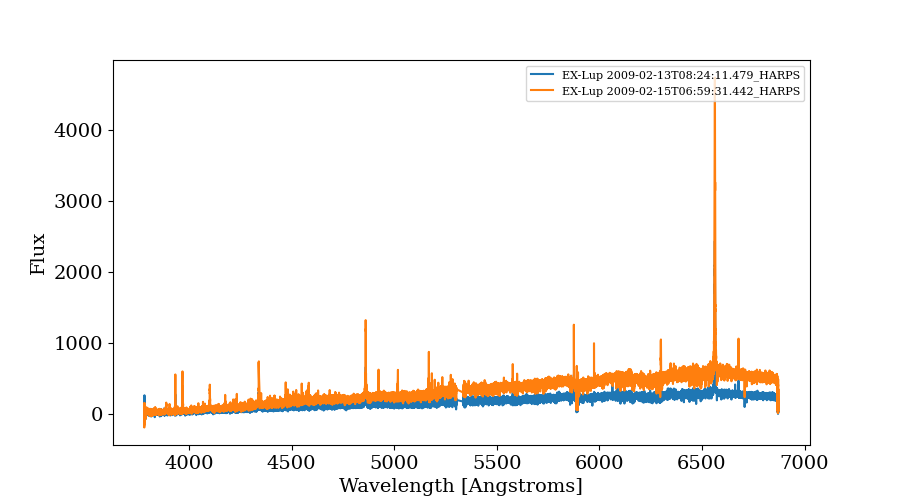

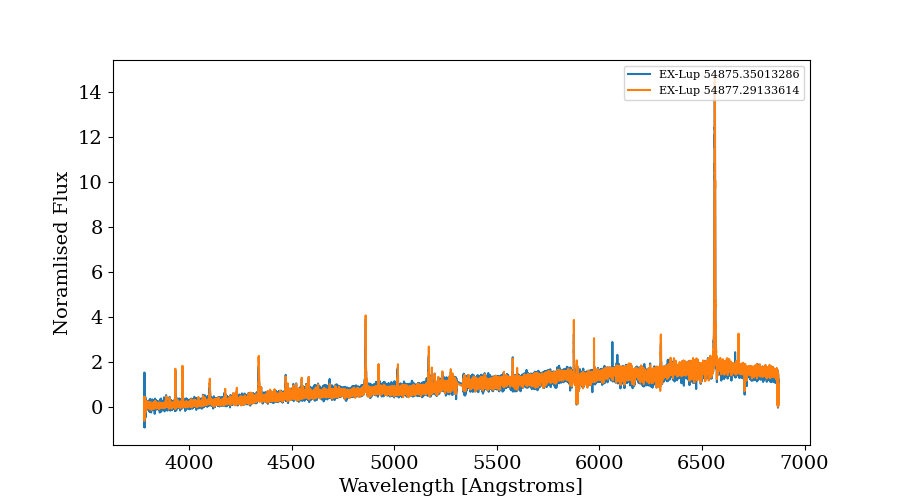

In [17]:
instr_select='any' 
if inst_select.value=='filtered table':
    new_list=qgrid_widget1.get_changed_df()
elif inst_select.value=='highlighted selection in table':
    new_list=qgrid_widget1.get_selected_df()
else:
    instr_select=inst_select.value
    new_list=data_dates_range1[data_dates_range1.inst==instr_select]
    
all_inst=True if len(unique(new_list.inst)) >1 else False

data_dates_range,instrument,w0=get_instrument_date_details(new_list.file,instr_select,
                                                           all_inst=all_inst,qgrid=False)#,start_date='2008',end_date='2012')
#w0=np.arange(min(w0),max(w0),1)
df_av=get_av_spec(data_dates_range,w0,norm=False,output=True,plot_av=False,savefig=False,label='utc_inst')
df_av_norm=get_av_spec(data_dates_range,w0,norm=True,output=True,plot_av=False)#,label='utc_inst')



#### Optional: query simbad for RV of star

In [18]:
customSimbad = Simbad()
customSimbad.add_votable_fields('sp','mk','velocity','rot','rv_value')
try:
    simbad=customSimbad.query_object(data_dates_range.target[0])
    radvel=simbad['RVZ_RADVEL'][0]
except:
    target=input('star name query failed, enter target name:   ')
    simbad=customSimbad.query_object(target)
    radvel=simbad['RVZ_RADVEL'][0]
print('radial velocity: ',radvel)

/Users/jcampbel/Library/Python/3.8/lib/python/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): 'EX-Lup': No known catalog could be found
  warnings.warn("Warning: The script line number %i raised "


star name query failed, enter target name:   ex lup
radial velocity:  1.9


### View individual lines from df_av dataframe

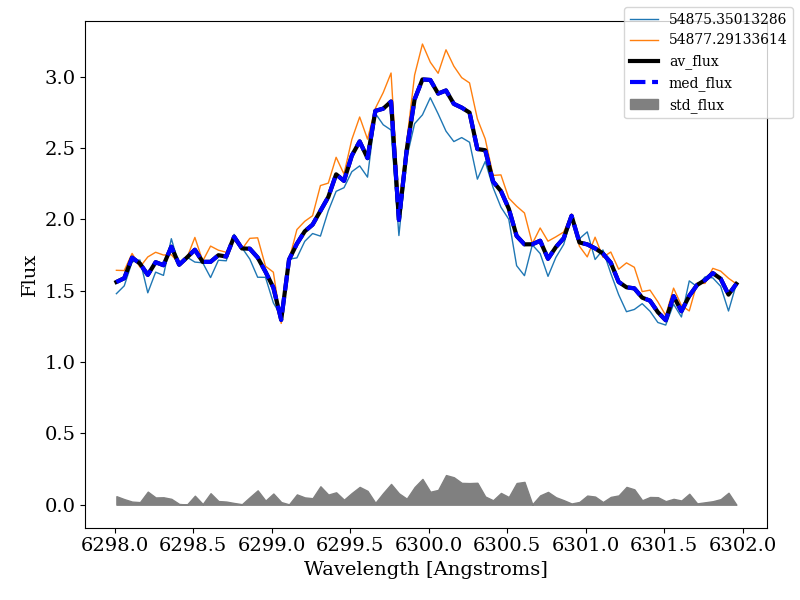

USH
USH


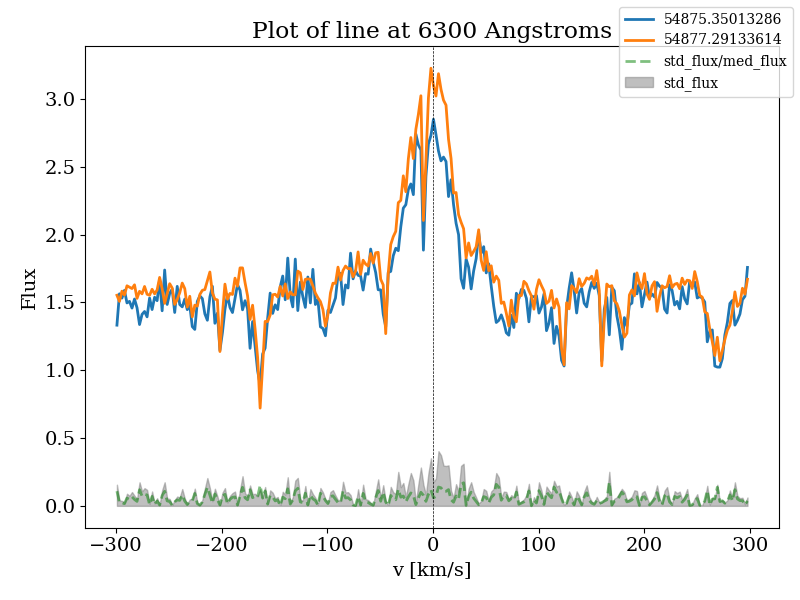

In [19]:
line=6300
vel_range=300
w_range=2
df_av_line_vel=get_line_spec(df_av_norm,line,vel_range,vel_offset=0,vel=True) #can set vel_offset to rv
df_av_line=get_line_spec(df_av_norm,line,w_range,vel_offset=0,vel=False)
wl_plot(df_av_line,plot_av=True,fs=USH.fig_size_s,legend=True)
vel_plot(df_av_line_vel,line=line,plot_av=False,plot_sd=True,fs=USH.fig_size_s)


### Line fitting options
* Use the select dates widget to pick all observation dates you want for the periodogram, drag click or shift click
* Options for number of Gaussians, 1, 2 or 3.
* If neg=True, one positive, one negative Gauss fitted, if neg=True and ngauss=2, two positive, one negative Gauss fitted etc
* May need to increase gof_min for >1 Gauss, defualt is gof_min=0.2


In [20]:
line_select = widget.FloatText(value='6563',step=1,description='Line wavelength (A)',layout={'width': 'max-content'}, style = {'description_width': 'initial'})
rv_select = widget.FloatText(value='0',step=1,description='Star Radial Velocity (km/s)',layout={'width': 'max-content'}, style = {'description_width': 'initial'})

date_selector = widget.SelectMultiple(options=df_av.columns[1:-1],value=['med_flux'],description='Select dates:',)
display(widget.HBox([line_select,rv_select,date_selector]))

vel_range=widget.FloatText(value='150',step=10,description='Velocity window',layout={'width': 'max-content'}, style = {'description_width': 'initial'})


ngauss_sel=widget.IntSlider(value='1',min=1,max=3,description='# of positive Gauss:', style = {'description_width': 'initial'})
neg_sel=widget.Checkbox(value=False,description='Include a negative Gauss?',layout={'width': 'max-content'}, style = {'description_width': 'initial'})
vred_sel=widget.Checkbox(value=False,description='Include a Vred calc.?',layout={'width': 'max-content'}, style = {'description_width': 'initial'})
gof_min_sel=widget.FloatSlider(min=0.1, max=1, step=0.1,value=0.2,description='GoF min:', style = {'description_width': 'initial'})
reject_low_gof=widget.Checkbox(value=False,description='Use min GoF?',layout={'width': 'max-content'}, style = {'description_width': 'initial'})
reject_line_close=widget.Checkbox(value=False,description='Use min std err?',layout={'width': 'max-content'}, style = {'description_width': 'initial'})

set_g1_cen=widget.Checkbox(value=False,description='Set G1 centre limits?',layout={'width': 'max-content'}, style = {'description_width': 'initial'})
set_g1_sig=widget.Checkbox(value=False,description='Set G1 sigma limits?',layout={'width': 'max-content'}, style = {'description_width': 'initial'})
g1_cen_min=widget.FloatText(value='0',step=10,description='G1 centre min',layout={'width': 'max-content'}, style = {'description_width': 'initial'})
g1_cen_max=widget.FloatText(value='20',step=10,description='max',layout={'width': 'max-content'}, style = {'description_width': 'initial'})
g1_sig_min=widget.FloatText(value='0',step=10,description='G1 sigma min',layout={'width': 'max-content'}, style = {'description_width': 'initial'})
g1_sig_max=widget.FloatText(value='50',step=10,description='max',layout={'width': 'max-content'}, style = {'description_width': 'initial'})

set_g2_cen=widget.Checkbox(value=False,description='Set G2 centre limits?',layout={'width': 'max-content'}, style = {'description_width': 'initial'})
set_g2_sig=widget.Checkbox(value=False,description='Set G2 sigma limits?',layout={'width': 'max-content'}, style = {'description_width': 'initial'})
g2_cen_min=widget.FloatText(value='10',step=10,description='G2 centre min',layout={'width': 'max-content'}, style = {'description_width': 'initial'})
g2_cen_max=widget.FloatText(value='50',step=10,description='max',layout={'width': 'max-content'}, style = {'description_width': 'initial'})
g2_sig_min=widget.FloatText(value='0',step=10,description='G2 sigma min',layout={'width': 'max-content'}, style = {'description_width': 'initial'})
g2_sig_max=widget.FloatText(value='100',step=10,description='max',layout={'width': 'max-content'}, style = {'description_width': 'initial'})

set_g3_cen=widget.Checkbox(value=False,description='Set G3 centre limits?',layout={'width': 'max-content'}, style = {'description_width': 'initial'})
set_g3_sig=widget.Checkbox(value=False,description='Set G3 sigma limits?',layout={'width': 'max-content'}, style = {'description_width': 'initial'})
g3_cen_min=widget.FloatText(value='10',step=10,description='G3 centre min',layout={'width': 'max-content'}, style = {'description_width': 'initial'})
g3_cen_max=widget.FloatText(value='50',step=10,description='max',layout={'width': 'max-content'}, style = {'description_width': 'initial'})
g3_sig_min=widget.FloatText(value='0',step=10,description='G3 sigma min',layout={'width': 'max-content'}, style = {'description_width': 'initial'})
g3_sig_max=widget.FloatText(value='100',step=10,description='max',layout={'width': 'max-content'}, style = {'description_width': 'initial'})

set_g4_cen=widget.Checkbox(value=False,description='Set neg Gauss centre limits?',layout={'width': 'max-content'}, style = {'description_width': 'initial'})
set_g4_sig=widget.Checkbox(value=False,description='Set neg Gauss sigma limits?',layout={'width': 'max-content'}, style = {'description_width': 'initial'})
g4_cen_min=widget.FloatText(value='10',step=10,description='neg centre min',layout={'width': 'max-content'}, style = {'description_width': 'initial'})
g4_cen_max=widget.FloatText(value='50',step=10,description='max',layout={'width': 'max-content'}, style = {'description_width': 'initial'})
g4_sig_min=widget.FloatText(value='0',step=10,description='neg sigma min',layout={'width': 'max-content'}, style = {'description_width': 'initial'})
g4_sig_max=widget.FloatText(value='100',step=10,description='max',layout={'width': 'max-content'}, style = {'description_width': 'initial'})

savefig=widget.Checkbox(value=False,description='Save all output plots to file?',layout={'width': 'max-content'}, style = {'description_width': 'initial'})
title=widget.Dropdown(options=['full','simple','none'],value='full',description='Plot title',layout={'width': 'max-content'}, style = {'description_width': 'initial'})
df_sel=widget.Dropdown(options=['df_av','df_av_norm'],value='df_av',description='Use df_av or df_av_norm?',layout={'width': 'max-content'}, style = {'description_width': 'initial'})

display(df_sel,vel_range)
display(widget.TwoByTwoLayout(top_left=widget.HBox([reject_low_gof,reject_line_close]),top_right=gof_min_sel,bottom_left=ngauss_sel,bottom_right=widget.HBox([neg_sel,vred_sel])))
display(widget.TwoByTwoLayout(bottom_left=widget.HBox([g1_cen_min,g1_cen_max]),bottom_right=widget.HBox([g1_sig_min,g1_sig_max]),top_left=set_g1_cen,top_right=set_g1_sig))
display(widget.TwoByTwoLayout(bottom_left=widget.HBox([g2_cen_min,g2_cen_max]),bottom_right=widget.HBox([g2_sig_min,g2_sig_max]),top_left=set_g2_cen,top_right=set_g2_sig))
display(widget.TwoByTwoLayout(bottom_left=widget.HBox([g3_cen_min,g3_cen_max]),bottom_right=widget.HBox([g3_sig_min,g3_sig_max]),top_left=set_g3_cen,top_right=set_g3_sig))
display(widget.TwoByTwoLayout(bottom_left=widget.HBox([g4_cen_min,g4_cen_max]),bottom_right=widget.HBox([g4_sig_min,g4_sig_max]),top_left=set_g4_cen,top_right=set_g4_sig))
display(widget.HBox([title,savefig]))
    

Dropdown(description='Use df_av or df_av_norm?', layout=Layout(width='max-content'), options=('df_av', 'df_av_…

FloatText(value=150.0, description='Velocity window', layout=Layout(width='max-content'), step=10.0, style=Des…

TwoByTwoLayout(children=(HBox(children=(Checkbox(value=False, description='Use min GoF?', layout=Layout(width=…

TwoByTwoLayout(children=(Checkbox(value=False, description='Set G1 centre limits?', layout=Layout(grid_area='t…

TwoByTwoLayout(children=(Checkbox(value=False, description='Set G2 centre limits?', layout=Layout(grid_area='t…

TwoByTwoLayout(children=(Checkbox(value=False, description='Set G3 centre limits?', layout=Layout(grid_area='t…

TwoByTwoLayout(children=(Checkbox(value=False, description='Set neg Gauss centre limits?', layout=Layout(grid_…

* *The next block runs the fitting for the lines and options selected above*
* *The option to output each plot on screen is given*


## Fit the lines

attempting fit of line at  6563.0
number of dates attempting to fit 2


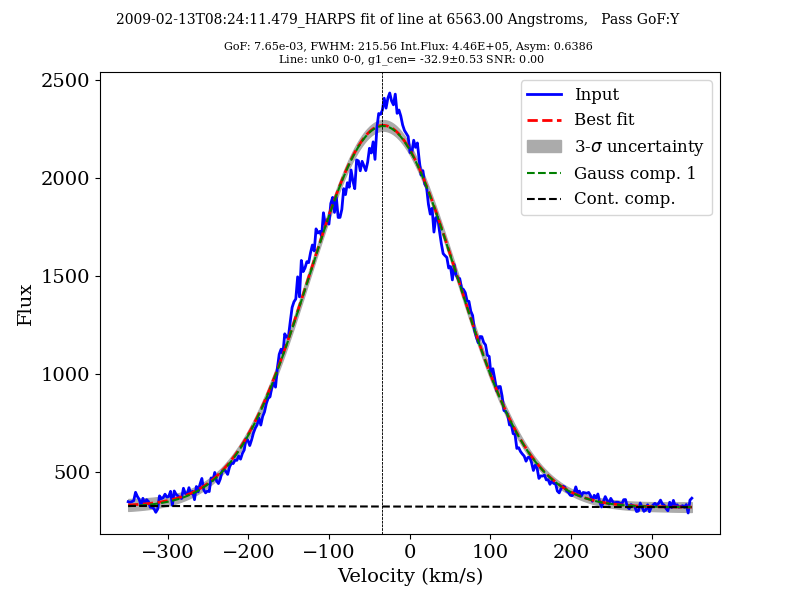

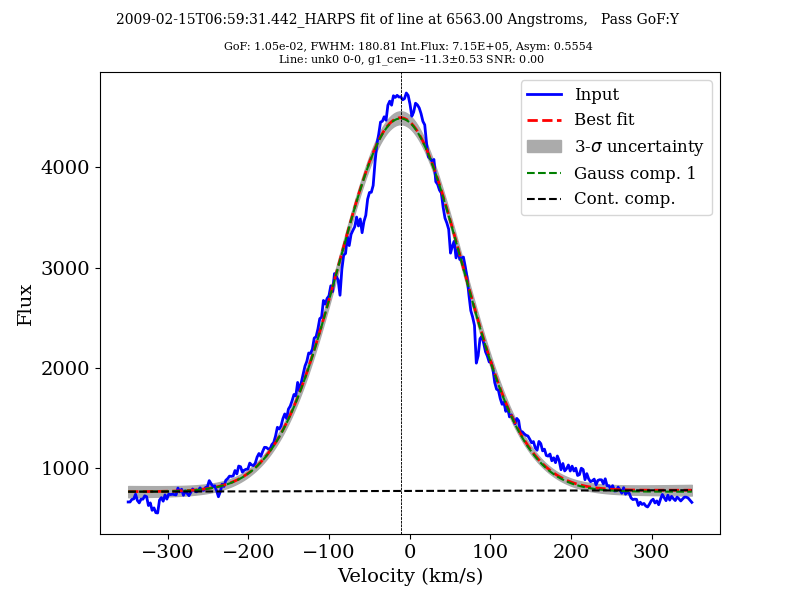

In [23]:
line_date_list=date_selector.value
line=line_select.value
radvel=rv_select.value
print('attempting fit of line at ',line)
print('number of dates attempting to fit %s'%(len(line_date_list)))

#settings for Vred H balmer: g1 cen -75,50, neg cen 150,250, neg sig 0,250
#settings for Vred Ca II k: g1 cen -20,20, g2 cen -30,20 neg cen 150,250, neg sig 0,250

g1_cen=[g1_cen_min.value,g1_cen_max.value] if set_g1_cen.value==True else None #0,150 for CaK + H
g2_cen=[g2_cen_min.value,g2_cen_max.value] if set_g2_cen.value==True else None #-20,100 for CaK
g3_cen=[g3_cen_min.value,g3_cen_max.value] if set_g3_cen.value==True else None #-20,100 for CaK
neg_cen=[g4_cen_min.value,g4_cen_max.value] if set_g4_cen.value==True else None #0,50 for He, 200,50 for CaK + H
g1_sig=[g1_sig_min.value,g1_sig_max.value] if set_g1_sig.value==True else None #0,50 for He, 200,50 for CaK + H
g2_sig=[g2_sig_min.value,g2_sig_max.value] if set_g2_sig.value==True else None #0,50 for He, 200,50 for CaK + H
g3_sig=[g3_sig_min.value,g3_sig_max.value] if set_g3_sig.value==True else None #0,50 for He, 200,50 for CaK + H
neg_sig=[g4_sig_min.value,g4_sig_max.value] if set_g4_sig.value==True else None #0,50 for He, 200,50 for CaK + H

df_fit=df_av if df_sel.value=='df_av' else df_av_norm

df_av_line_vel=get_line_spec(df_fit,line,vel_range.value,vel_offset=radvel,vel=True)
line_results=pd.DataFrame()

for date in date_selector.value:
    out,x,y,line_info=gauss_stats(df_av_line_vel,date,em_row=line,
                                  ngauss=ngauss_sel.value,output=True,
                                g1_cen=g1_cen,g2_cen=g2_cen,g3_cen=g3_cen,neg_cen=neg_cen,g1_sig=g1_sig,g2_sig=g2_sig,g3_sig=g3_sig,neg_sig=neg_sig,
                                neg=neg_sel.value,gof_min=gof_min_sel.value,vred=vred_sel.value,plot_comps=True,
                                savefig=savefig.value,reject_low_gof=reject_low_gof.value,reject_line_close=reject_line_close.value)
    line_results=pd.concat([line_results,line_info],axis=1,ignore_index=True)
line_results=line_results.T    


In [24]:
pd.set_option('display.float_format', lambda x: '%.3e' % x)
line_results

,mjd,gof,g1_cen,g1_stderr,g1_sigma,g1_fwhm,g1_fwhm_stderr,g1_amp,g1_amp_stderr,peak,asym,int_flux,EW,Vred
0,2009-02-13T08:24:11.479_HARPS,7.645e-03,-3.287e+01,5.314e-01,9.154e+01,2.156e+02,1.509e+00,4.464e+05,3.745e+03,2.143e+03,6.386e-01,4.463e+05,3.031e+01,0
1,2009-02-15T06:59:31.442_HARPS,1.048e-02,-1.126e+01,5.294e-01,7.678e+01,1.808e+02,1.423e+00,7.153e+05,6.242e+03,4.450e+03,5.554e-01,7.153e+05,2.017e+01,0


You can save this dataframe to csv for further analysis
'line_results.to_csv()'

Some further examples from STAR-MELT that should be simple to run...

For the full demonstration see the example_notebook

### X-corr plot of two lines

vel plot of line(s), including undersample factor:
USH
USH


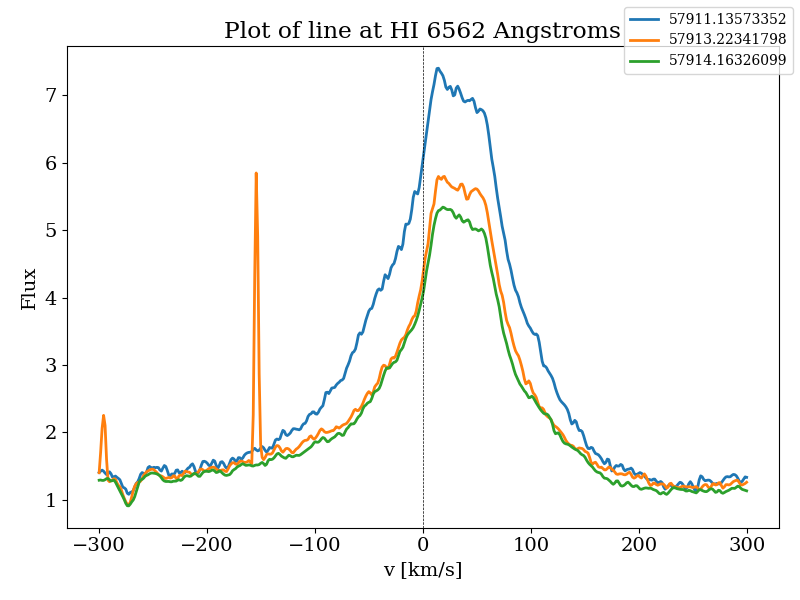

USH
USH


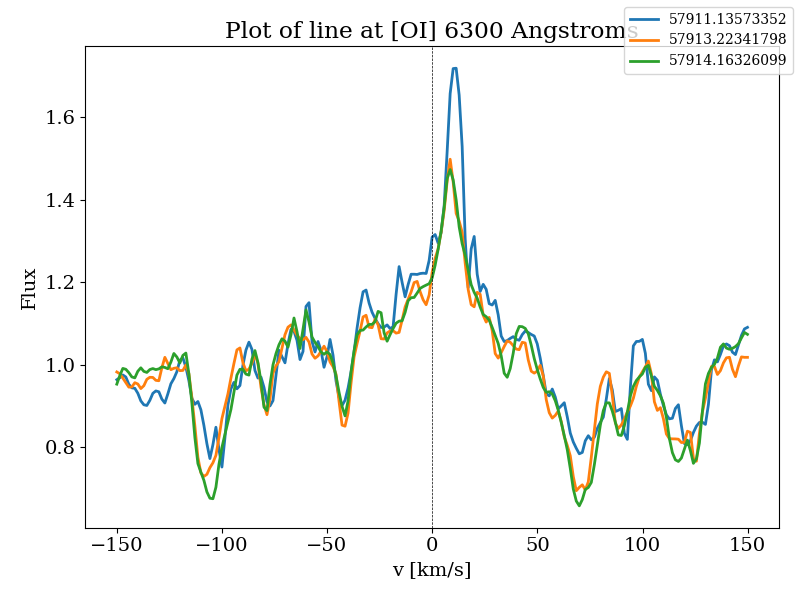

xcorr plot:
fraction of sectors with positive corr > r=0.6:


,line2 blue,line2 red
line1 blue,2.100e-01,3.200e-01
line1 red,2.100e-01,3.300e-01


fraction of sectors with negative corr < r=0.6:


,line2 blue,line2 red
line1 blue,2.100e-01,5.000e-02
line1 red,2.200e-01,5.000e-02


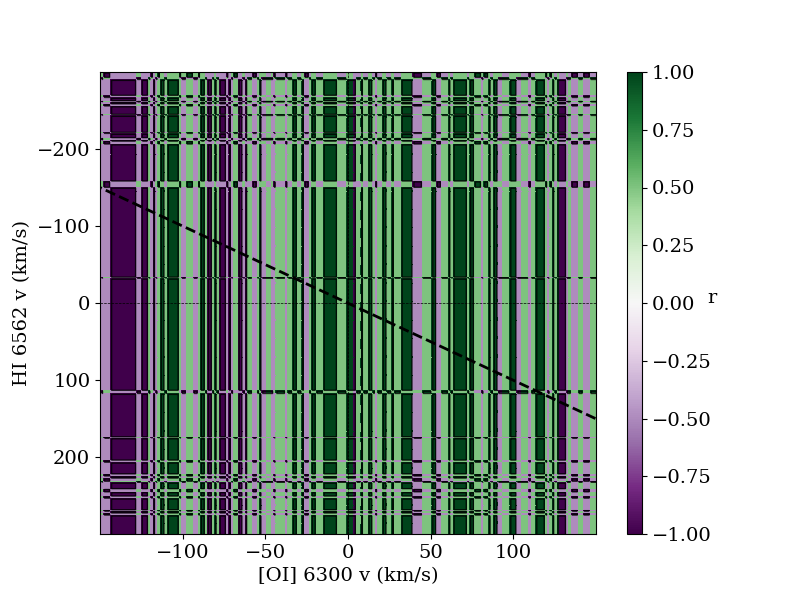

In [15]:
df_av_line_vel=get_line_spec(df_av_norm,6562,300,vel_offset=radvel,vel=True) #best to use normalised df
df_av_line_vel2=get_line_spec(df_av_norm,6300,150,vel_offset=0,vel=True) #can specify v_range and offset manually

# if no df2 given then does auto-corr for df1, line1 and line2 are strings for plot
# undersample is the factor to reduce resolution by, fs = fig size
# mask for quadrant fractions and optionally plot at specified r value
# c_lvls are the p values to plot contours
xcor,pcor,quad_pos,quad_neg=vel_xcorr(df1=df_av_line_vel,df2=df_av_line_vel2,line1='HI 6562',line2='[OI] 6300',
               undersample=3,fs=(8,6),mask=0.6,c_lvls=[0.05],masked_plot=False)



### Plot the Halpha line for all stars within data_dir
* This block will go through all of the data available within the specified data_dir, find which spectra cover the Halpha wavelength and plot the line, option to view or save is given in the final line
* Set up so no user input required, scope for further lines and fitting to be included here too for known lines
* stars need to be organised in folders within data_dir, can run organise_fits_files() on directory of .fits files to sort...

In [68]:
star_list=os.listdir(data_dir)

In [ ]:
line=6563 #Halpha
#line=4861 #Hbeta
#line=5016 #HeI
#line=4686 #HeII
for star in star_list: #loop through all stars in data_dir
    data_fits_files=get_files(os.path.join(data_dir,star),'.fits','.FTZ') #get filenames of .fits files
    standard_fits_files,mk,stype,st_rv,simbad=get_fits_files_simbad(star,standards_dir,simbad_out=True) #check name is resolved in SIMBAD, only used for printing for now but can be used to get RV if fitting added here
    data_dates_range1,instrument,w0=get_instrument_date_details(data_fits_files,qgrid=True) #get instrument details so that we can find which ones cover Halpha
    for wmin in unique(np.round(data_dates_range1.wmin,0)): #loop through the unique wmin values, this will allow for the following steps to be completely automatic with no user input needed
        new_list=data_dates_range1[np.round(data_dates_range1.wmin,0)==wmin]
        if new_list.iloc[0].wmin < (line/10)-5 and new_list.iloc[0].wmax > (line/10)+5: #check data covers Halpha
            rep_char='. '
            for char in rep_char:
                star=star.replace(char,'')
            USH.target=star #for figure filenames
            USH.instrument=new_list.iloc[0].inst #for figure filenames
            data_dates_range,instrument,w0=get_instrument_date_details(new_list.file,qgrid=False) #select obs
            df_av=get_av_spec(data_dates_range,w0,norm=False,output=False,plot_av=True,savefig=False)#,label='utc_inst')
            df_av_norm=get_av_spec(data_dates_range,w0,norm=True,output=False,plot_av=True,label='utc_inst') #get av spec
            line=line
            w_range=10 #Angstrom range to plot
            df_av_line=get_line_spec(df_av_norm,line,w_range,vel_offset=0,vel=False) #get line spec, RV not considered yet 
            wl_plot(df_av_line,plot_av=True,fs=USH.fig_size_s,output=False,savefig=True,legend=False) #plot show/save the Halpha lines